In [ ]:
import os, sys, cv2
import seaborn as sn
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input

from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, MaxPool1D, GaussianNoise, GlobalMaxPooling1D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.layers import LeakyReLU
import tensorflow
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [ ]:
os.chdir('/content/drive/MyDrive/Project/')

In [ ]:
# load the .npz file of features
f = np.load(os.getcwd()+"/MusicFeatures.npz")
S = f['spec']
mfcc = f['mfcc']
mel = f['mel']
y = f['target']


In [ ]:
print(S.shape)
print(mfcc.shape)
print(mel.shape)
print(y.shape)


(945, 1025, 1293)
(945, 10, 1293)
(945, 128, 1293)
(944, 10)


In [ ]:
# Find the minimum number of samples among all arrays
min_samples = min(S.shape[0], mfcc.shape[0], mel.shape[0], y.shape[0])

# Truncate or pad each array to have the same number of samples
S = S[:min_samples]
mfcc = mfcc[:min_samples]
mel = mel[:min_samples]

y = y[:min_samples]

#train
S_train, S_test, mfcc_train, mfcc_test, mel_train, mel_test, y_train, y_test = train_test_split(S, mfcc, mel, y, test_size=0.2)


In [ ]:
# Spectrogram
maximum1 = np.amax(S_train)
S_train = S_train/np.amax(maximum1)
S_test = S_test/np.amax(maximum1)

S_train = S_train.astype(np.float32)
S_test = S_test.astype(np.float32)

N, row, col = S_train.shape
S_train = S_train.reshape((N, row, col, 1))

N, row, col = S_test.shape
S_test = S_test.reshape((N, row, col, 1))

In [ ]:
# MFCC
newtrain_mfcc = np.empty((mfcc_train.shape[0], 120, 600))
newtest_mfcc = np.empty((mfcc_test.shape[0], 120, 600))

for i in range(mfcc_train.shape[0]) :
    curr = mfcc_train[i]
    curr = cv2.resize(curr, (600, 120))
    newtrain_mfcc[i] = curr

mfcc_train = newtrain_mfcc

for i in range(mfcc_test.shape[0]) :

  curr = mfcc_test[i]
  curr = cv2.resize(curr, (600, 120))
  newtest_mfcc[i] = curr

mfcc_test = newtest_mfcc

mfcc_train = mfcc_train.astype(np.float32)
mfcc_test = mfcc_test.astype(np.float32)

N, row, col = mfcc_train.shape
mfcc_train = mfcc_train.reshape((N, row, col, 1))

N, row, col = mfcc_test.shape
mfcc_test = mfcc_test.reshape((N, row, col, 1))

mean_data = np.mean(mfcc_train)
std_data = np.std(mfcc_train)

mfcc_train = (mfcc_train - mean_data)/ std_data
mfcc_test = (mfcc_test - mean_data)/ std_data

In [ ]:
# Mel-Spectrogram
maximum = np.amax(mel_train)
mel_train = mel_train/np.amax(maximum)
mel_test = mel_test/np.amax(maximum)

mel_train = mel_train.astype(np.float32)
mel_test = mel_test.astype(np.float32)

N, row, col = mel_train.shape
mel_train = mel_train.reshape((N, row, col, 1))

N, row, col = mel_test.shape
mel_test = mel_test.reshape((N, row, col, 1))

In [ ]:
# Save Spectrogram train-test
np.savez_compressed(os.getcwd()+"/new_spectrogram_train_test.npz", S_train= S_train, S_test= S_test, y_train = y_train, y_test= y_test)

# Save MFCC train-test
np.savez_compressed(os.getcwd()+"/new_mfcc_train_test.npz", mfcc_train= mfcc_train, mfcc_test= mfcc_test, y_train = y_train, y_test= y_test)

# Save Mel-Spectrogram train-test
np.savez_compressed(os.getcwd()+"/new_mel_train_test.npz", mel_train= mel_train, mel_test= mel_test, y_train = y_train, y_test= y_test)


In [ ]:
# Load Spectrogram Train-test data
spec_file = np.load(os.getcwd()+"/new_spectrogram_train_test.npz")

# Model 1 for Spectrogram
S_train = spec_file['S_train']
S_test = spec_file['S_test']
y_train = spec_file['y_train']
y_test = spec_file['y_test']

model = Sequential()
model.add(Conv2D(8, (3,3), activation= 'relu', input_shape= S_train[0].shape, padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(16, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(32, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Flatten())
model.add(Dense(128, activation= 'relu'))
model.add(Dense(64, activation= 'relu'))
model.add(Dense(10, activation= 'softmax'))

model.compile(optimizer= 'Adam', loss= 'categorical_crossentropy')
model.summary()
# Train Model 1
checkpoint = ModelCheckpoint(os.getcwd()+"/models/new_spec_model_spectrogram1_{epoch:03d}.h5", period= 5)
model.fit(S_train, y_train, epochs= 100, callbacks= [checkpoint], batch_size= 32, verbose= 1)
model.save(os.getcwd() + "/models/new_spec_model_spectrogram1.h5")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1025, 1293, 8)     80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 257, 324, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 257, 324, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 65, 81, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 65, 81, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 21, 32)        0

20/20 [==============================] - 2s 88ms/step
Train Accuracy:  609 / 640  =  95.16 %
6/6 [==============================] - 1s 79ms/step
Test Accuracy:  148 / 161  =  91.93 %


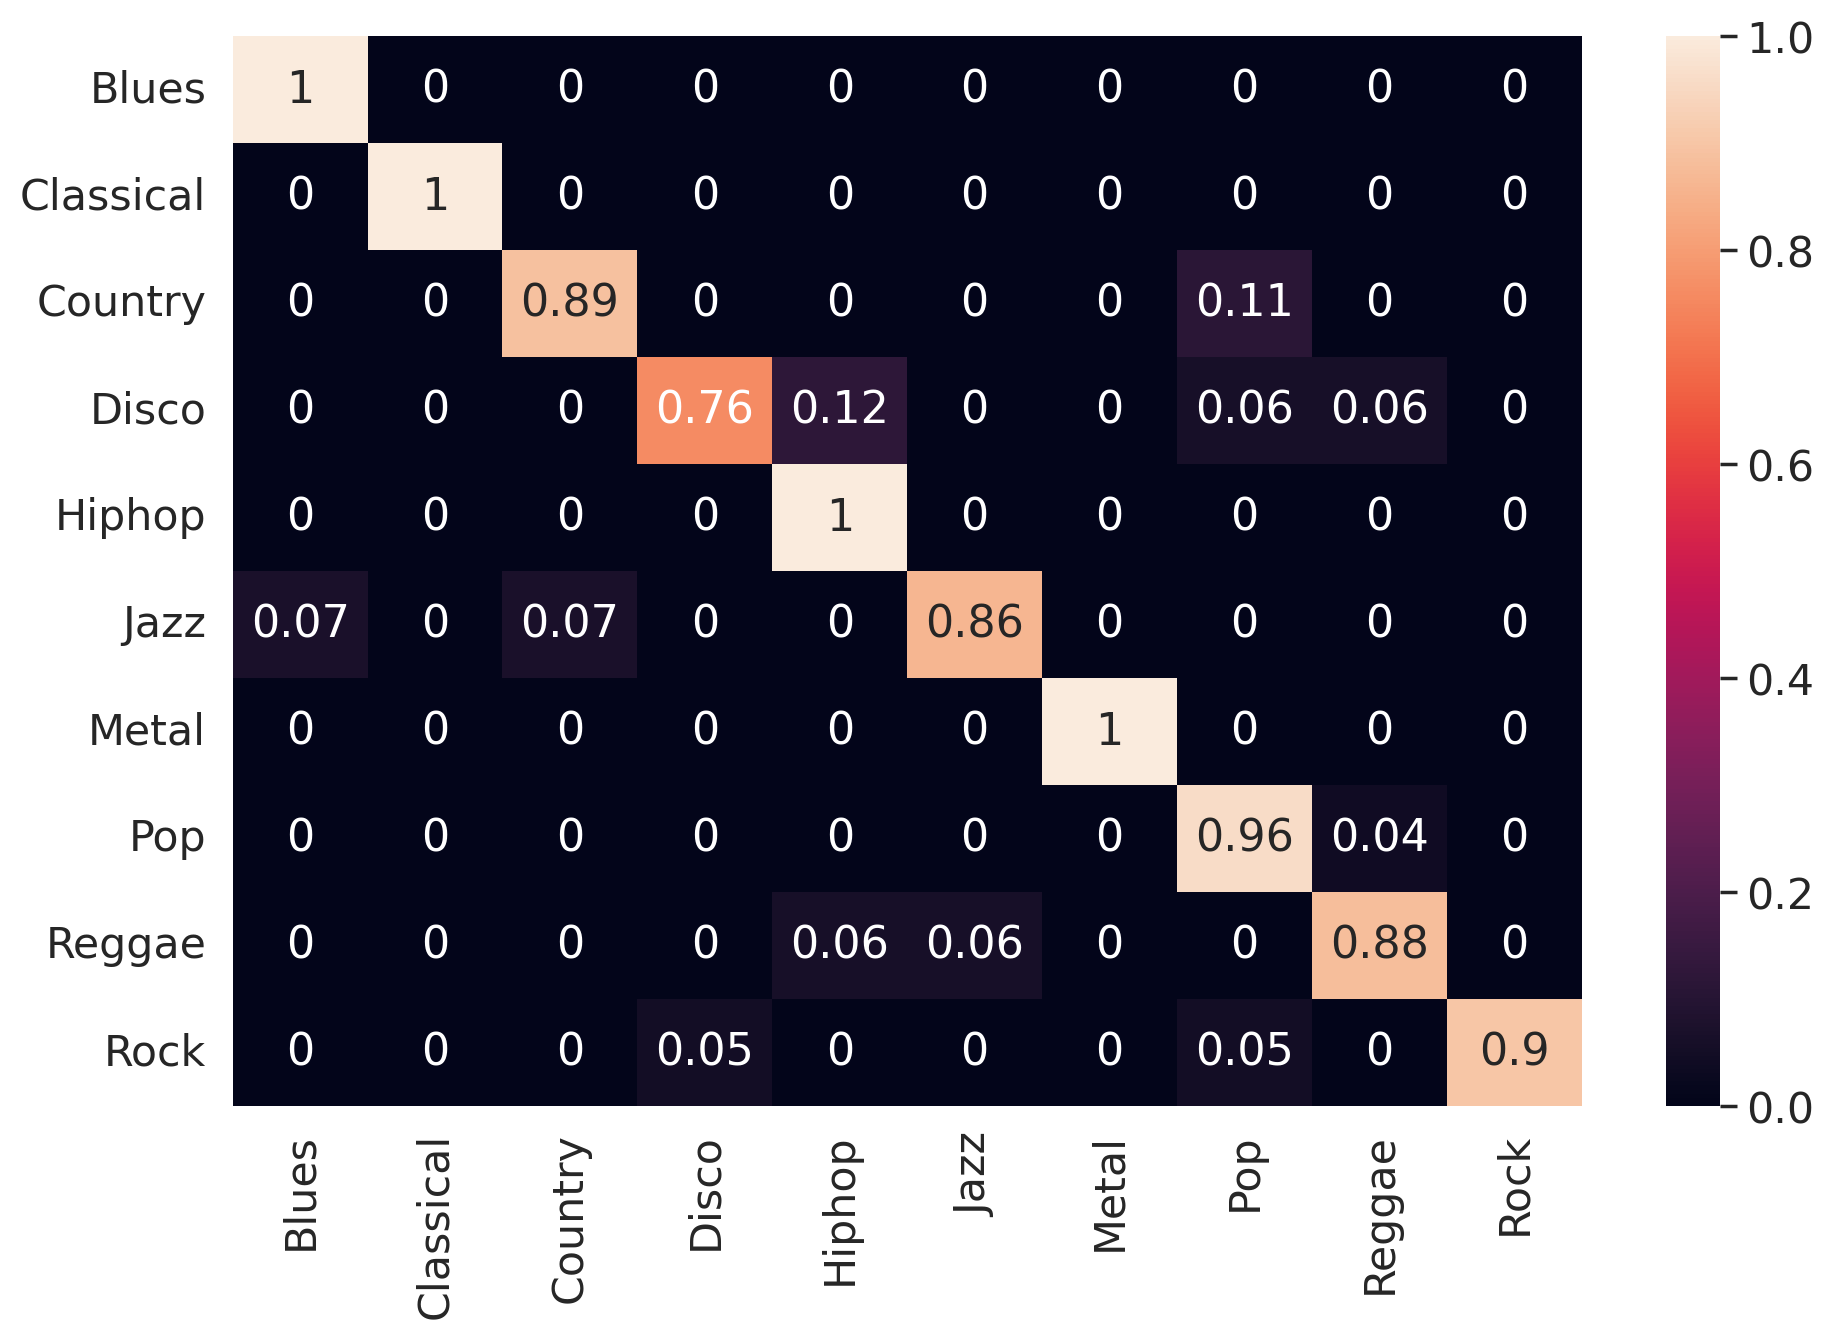

In [ ]:
model = load_model(os.getcwd() + "/models/new_spec_model_spectrogram1_100.h5")

# Training Accuracy
y_pred = model.predict(S_train)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_train, axis= -1)

correct = len(y_pred) - np.count_nonzero(y_pred - y_true)
acc = correct/ len(y_pred)
acc = np.round(acc, 4) * 100

print("Train Accuracy: ", correct, "/", len(y_pred), " = ", acc, "%")

# # Testing Accuracy
y_pred = model.predict(S_test)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_test, axis= -1)

correct = len(y_pred) - np.count_nonzero(y_pred - y_true)
acc = correct/ len(y_pred)
acc = np.round(acc, 4) * 100

print("Test Accuracy: ", correct, "/", len(y_pred), " = ", acc, "%")

class_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]
conf_mat = confusion_matrix(y_true, y_pred, normalize= 'true')
conf_mat = np.round(conf_mat, 2)

conf_mat_df = pd.DataFrame(conf_mat, columns= class_names, index= class_names)

plt.figure(figsize = (10,7), dpi = 200)
sn.set(font_scale=1.4)
sn.heatmap(conf_mat_df, annot=True, annot_kws={"size": 16}) # font size
plt.tight_layout()
plt.savefig(os.getcwd() + "/new_spec_conf_mat1.png")


# CNN MFCC

In [ ]:
# Load MFCC file
mfcc_file = np.load(os.getcwd() + "/new_mfcc_train_test.npz")
mfcc_train = mfcc_file['mfcc_train']
mfcc_test = mfcc_file['mfcc_test']
y_train = mfcc_file['y_train']
y_test = mfcc_file['y_test']

In [ ]:
# Define model for MFCC
def get_model():
    model = Sequential()
    model.add(Conv2D(8, (3, 3), input_shape=mfcc_train[0].shape, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((4, 4), padding='same'))
    model.add(Conv2D(16, (3, 3), input_shape=mfcc_train[0].shape, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((4, 4), padding='same'))
    model.add(Conv2D(32, (3, 3), input_shape=mfcc_train[0].shape, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((4, 4), padding='same'))
    model.add(Conv2D(64, (3, 3), input_shape=mfcc_train[0].shape, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((4, 4), padding='same'))
    model.add(Conv2D(64, (3, 3), input_shape=mfcc_train[0].shape, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((4, 4), padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='Adam', loss='categorical_crossentropy')

    model.summary()

    return model

# Get the model
model = get_model()

# Fit the model to your data
history = model.fit(mfcc_train, y_train, epochs=100, batch_size=32, verbose=1)

# Save the trained model
model.save(os.getcwd() + "/models/new_mfcc_model.h5")


KeyboardInterrupt: ignored

20/20 [==============================] - 0s 10ms/step
Train Accuracy:  640 / 640  =  100.0 %
6/6 [==============================] - 0s 20ms/step
Test Accuracy:  102 / 161  =  63.349999999999994 %


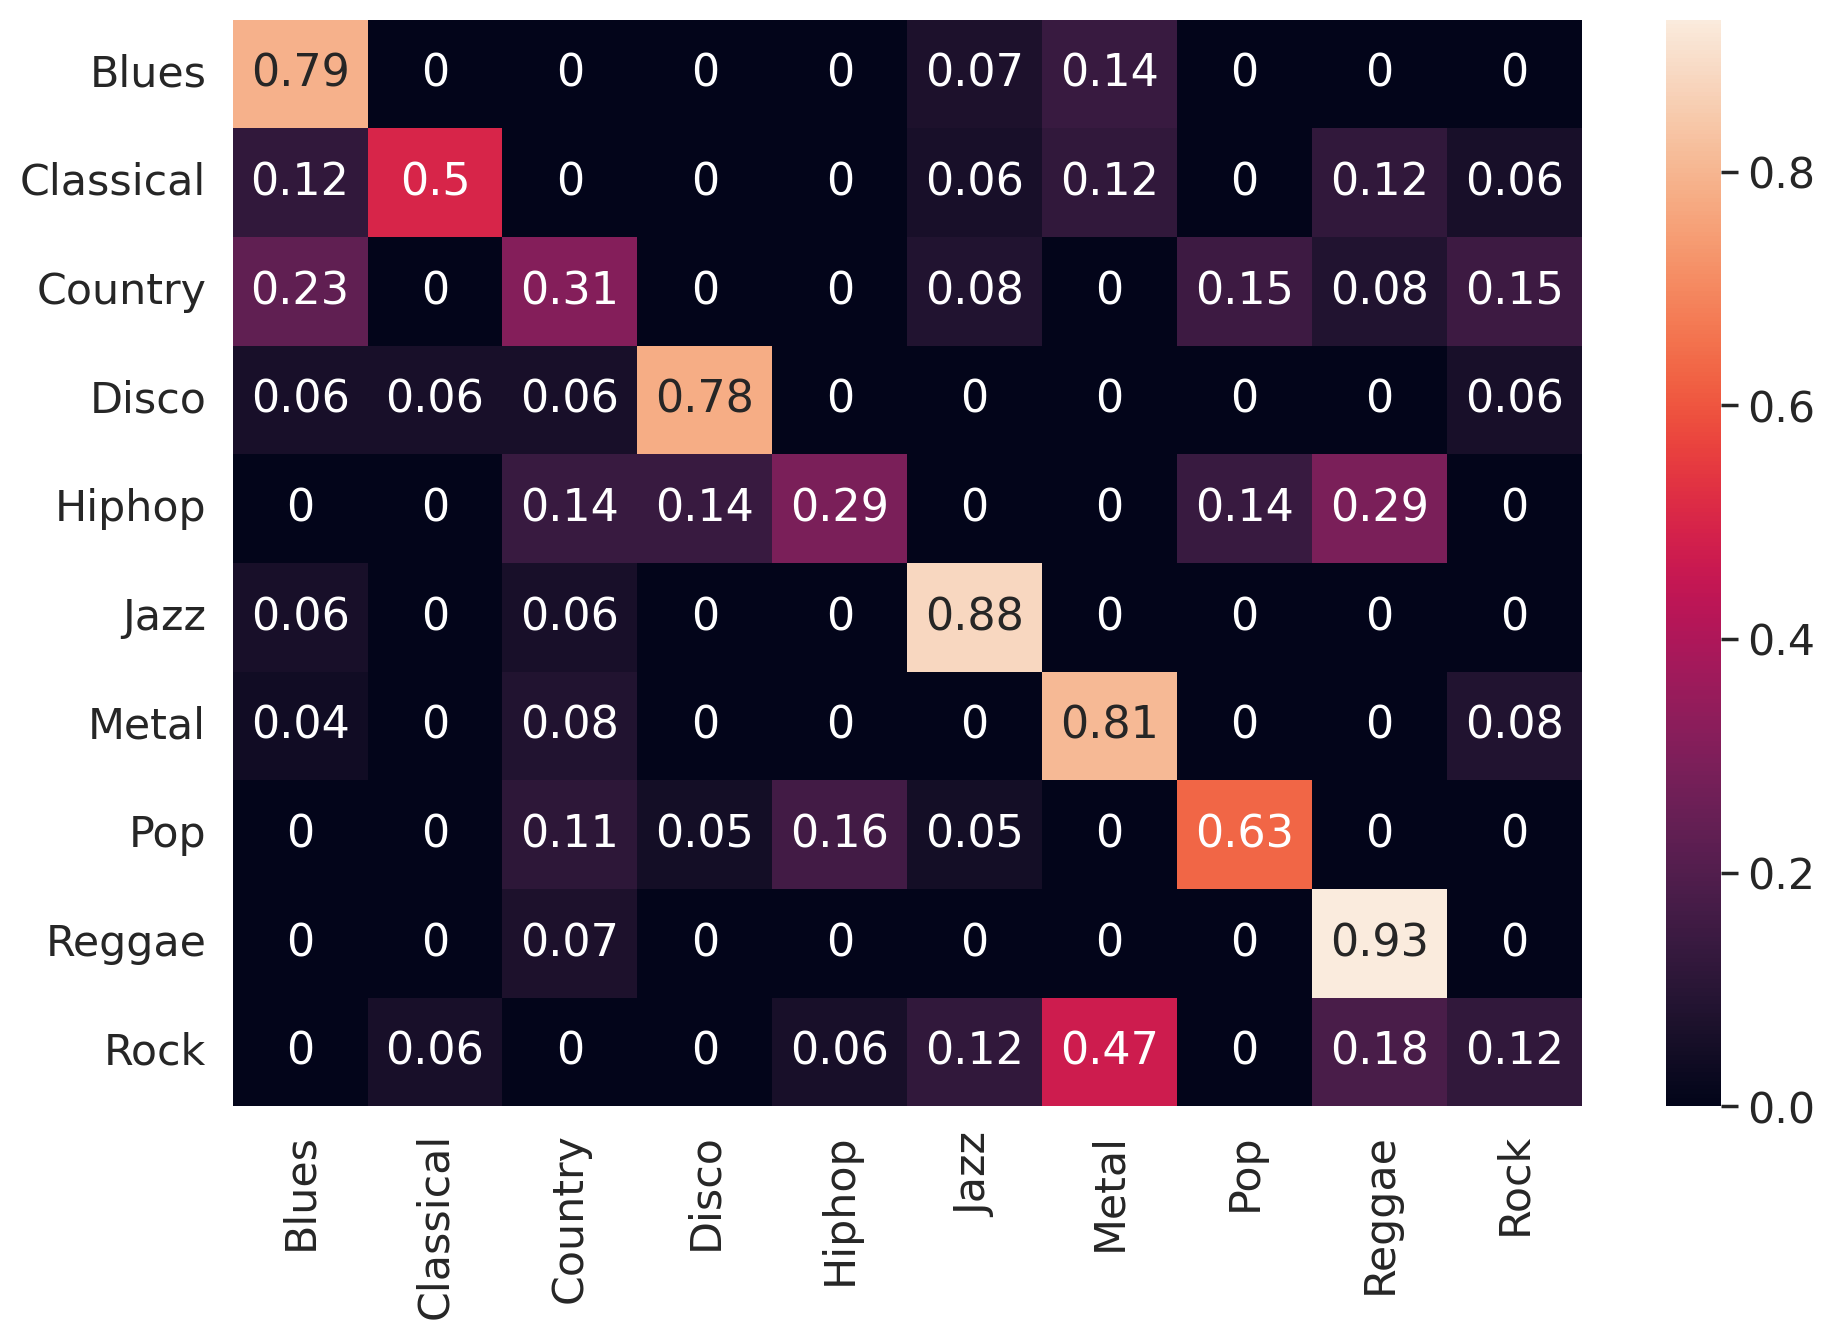

In [ ]:
model = load_model(os.getcwd() + "/models/new_mfcc_model.h5")

# Training Accuracy
y_pred = model.predict(mfcc_train)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_train, axis= -1)

correct = len(y_pred) - np.count_nonzero(y_pred - y_true)
acc = correct/ len(y_pred)
acc = np.round(acc, 4) * 100

print("Train Accuracy: ", correct, "/", len(y_pred), " = ", acc, "%")

# # Testing Accuracy
y_pred = model.predict(mfcc_test)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_test, axis= -1)

correct = len(y_pred) - np.count_nonzero(y_pred - y_true)
acc = correct/ len(y_pred)
acc = np.round(acc, 4) * 100

print("Test Accuracy: ", correct, "/", len(y_pred), " = ", acc, "%")

class_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]
conf_mat = confusion_matrix(y_true, y_pred, normalize= 'true')
conf_mat = np.round(conf_mat, 2)

conf_mat_df = pd.DataFrame(conf_mat, columns= class_names, index= class_names)

plt.figure(figsize = (10,7), dpi = 200)
sn.set(font_scale=1.4)
sn.heatmap(conf_mat_df, annot=True, annot_kws={"size": 16}) # font size
plt.tight_layout()
plt.savefig(os.getcwd() + "/new_spec_conf_mat1.png")


this model has over fitting

## model for fixing over fitting

In [ ]:
import os
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler



# Define model for MFCC
def get_model():
    model = Sequential()
    model.add(Conv2D(8, (3, 3), input_shape=mfcc_train[0].shape, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((4, 4), padding='same'))
    model.add(Conv2D(16, (3, 3), input_shape=mfcc_train[0].shape, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((4, 4), padding='same'))
    model.add(Conv2D(32, (3, 3), input_shape=mfcc_train[0].shape, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((4, 4), padding='same'))
    model.add(Conv2D(64, (3, 3), input_shape=mfcc_train[0].shape, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((4, 4), padding='same'))
    model.add(Conv2D(64, (3, 3), input_shape=mfcc_train[0].shape, activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((4, 4), padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()

    return model

# Get the model
model = get_model()

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(scheduler)

# Fit the model to your data
history = model.fit(mfcc_train, y_train, epochs=100, batch_size=32, callbacks=[lr_scheduler], verbose=1)

# Save the trained model
model.save(os.getcwd() + "/models/new_mfcc_model_overfittingfix.h5")


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 120, 600, 8)       80        
                                                                 
 batch_normalization_7 (Bat  (None, 120, 600, 8)       32        
 chNormalization)                                                
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 30, 150, 8)        0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 30, 150, 16)       1168      
                                                                 
 batch_normalization_8 (Bat  (None, 30, 150, 16)       64        
 chNormalization)                                                
                                                      

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 0s 7ms/step
Train Accuracy:  640 / 640  =  100.0 %
6/6 [==============================] - 0s 7ms/step
Test Accuracy:  91 / 161  =  56.52 %


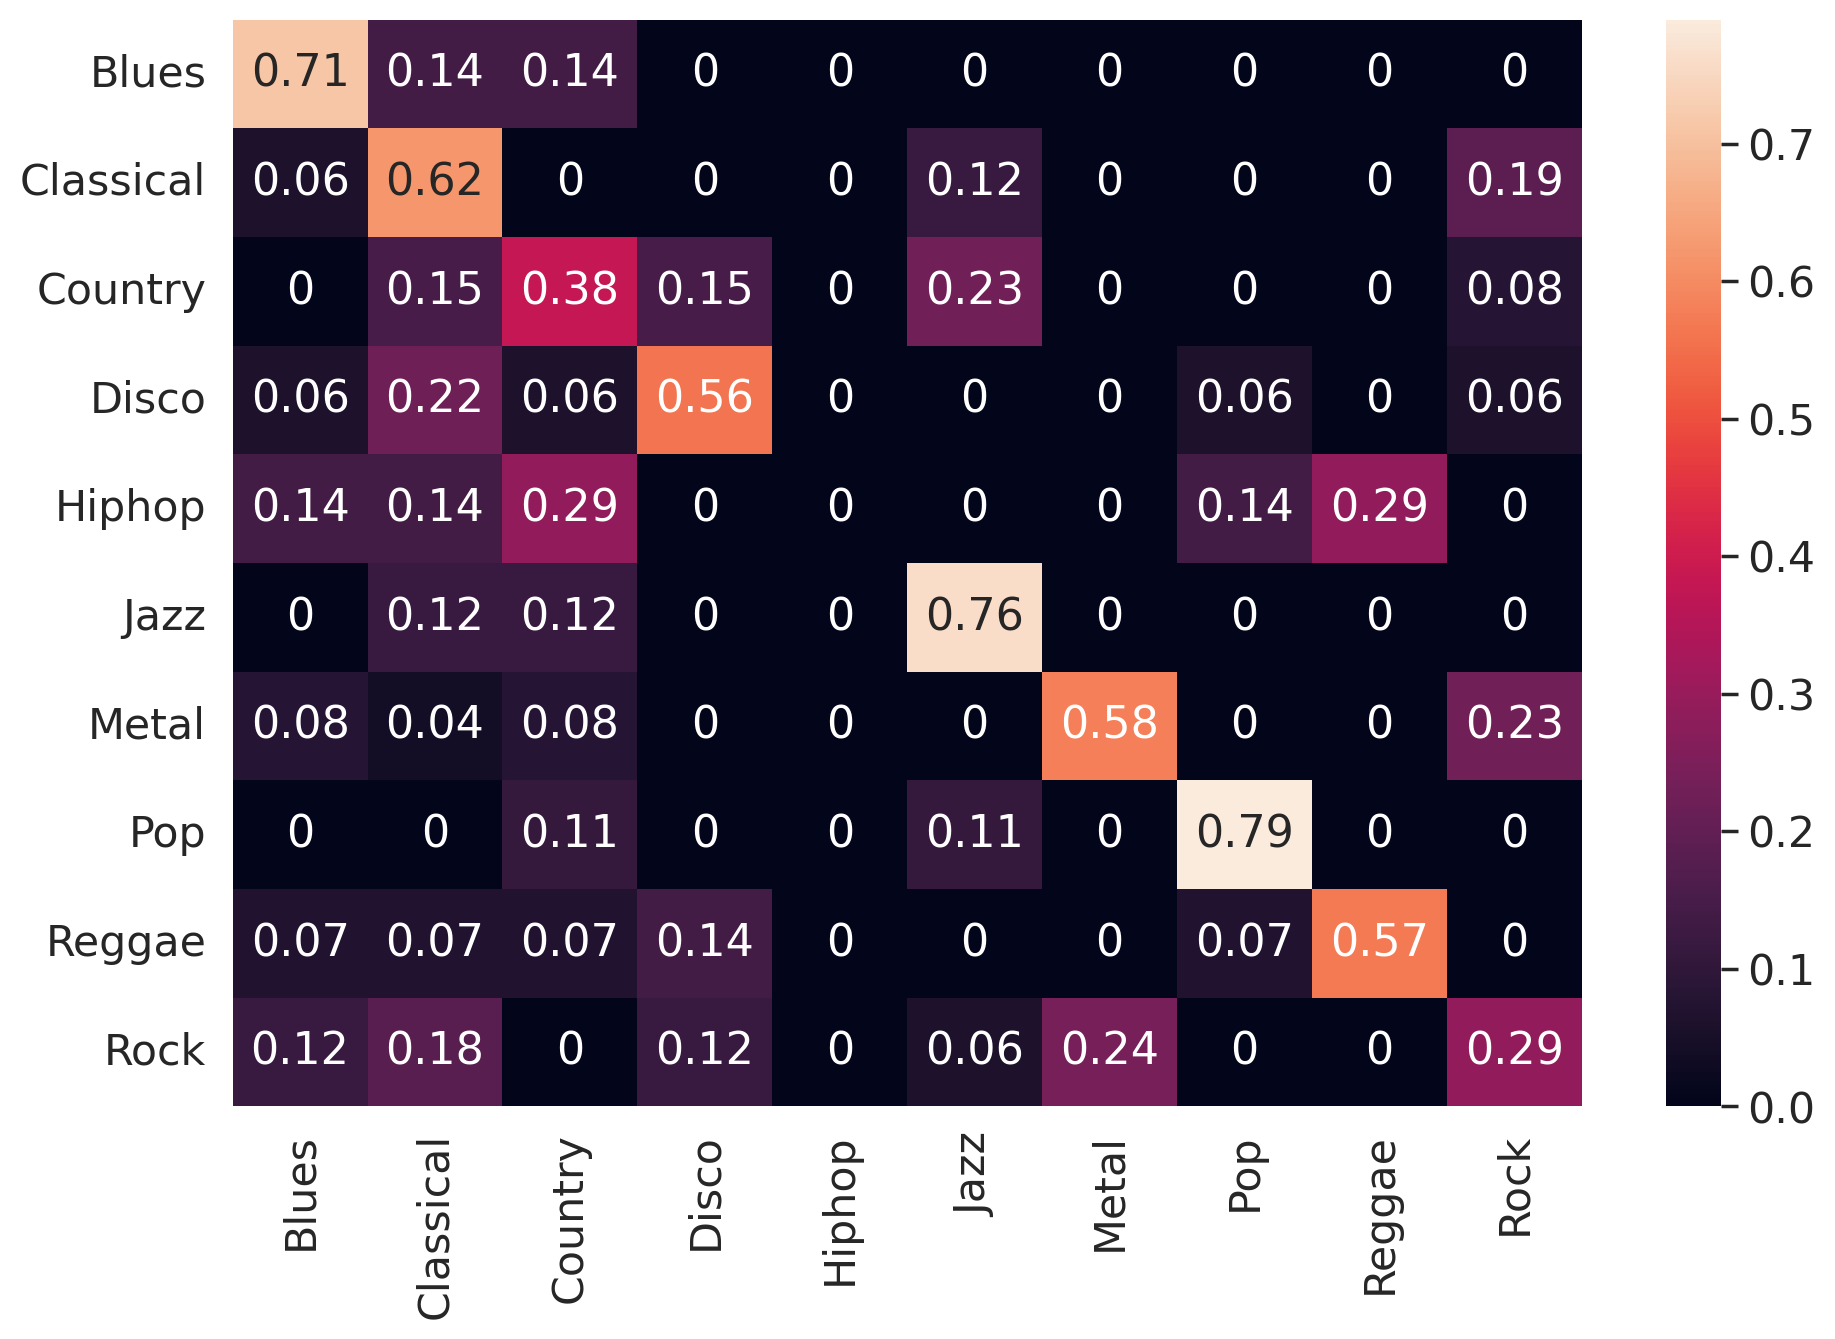

In [ ]:
model = load_model(os.getcwd() + "/models/new_mfcc_model_overfittingfix.h5")

# Training Accuracy
y_pred = model.predict(mfcc_train)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_train, axis= -1)

correct = len(y_pred) - np.count_nonzero(y_pred - y_true)
acc = correct/ len(y_pred)
acc = np.round(acc, 4) * 100

print("Train Accuracy: ", correct, "/", len(y_pred), " = ", acc, "%")

# # Testing Accuracy
y_pred = model.predict(mfcc_test)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_test, axis= -1)

correct = len(y_pred) - np.count_nonzero(y_pred - y_true)
acc = correct/ len(y_pred)
acc = np.round(acc, 4) * 100

print("Test Accuracy: ", correct, "/", len(y_pred), " = ", acc, "%")

class_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]
conf_mat = confusion_matrix(y_true, y_pred, normalize= 'true')
conf_mat = np.round(conf_mat, 2)

conf_mat_df = pd.DataFrame(conf_mat, columns= class_names, index= class_names)

plt.figure(figsize = (10,7), dpi = 200)
sn.set(font_scale=1.4)
sn.heatmap(conf_mat_df, annot=True, annot_kws={"size": 16}) # font size
plt.tight_layout()
plt.savefig(os.getcwd() + "/new_spec_conf_mat1.png")


## model 2


In [ ]:
from tensorflow import keras

# Define model for MFCC
def get_model():
    model = keras.models.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=mfcc_train[0].shape, name='conv1'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization(name='batch_norm1'))

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv2'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization(name='batch_norm2'))

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu', name='conv3'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization(name='batch_norm3'))

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu', name='dense1'))
    model.add(keras.layers.Dropout(0.3, name='dropout1'))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax', name='output'))

    model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    model.summary()

    return model

# Get the model
model = get_model()

# Fit the model to your data
history = model.fit(mfcc_train, y_train, epochs=100, batch_size=32, verbose=1)

# Save the trained model
model.save(os.getcwd() + "/models/new_mfcc_model.h5")


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 118, 598, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 299, 32)       0         
 D)                                                              
                                                                 
 batch_norm1 (BatchNormaliz  (None, 59, 299, 32)       128       
 ation)                                                          
                                                                 
 conv2 (Conv2D)              (None, 57, 297, 32)       9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 29, 149, 32)       0         
 g2D)                                                            
                                                      

ValueError: ignored

### model 3 to try improve accuracy

# CNN MEL SPECTROGRAM

In [ ]:
# Mel-Sprectrogram

file = np.load(os.getcwd()+"/new_mel_train_test.npz")
mel_train = file['mel_train']
mel_test = file['mel_test']
y_train = file['y_train']
y_test = file['y_test']


model = Sequential()
model.add(Conv2D(8, (3,3), activation= 'relu', input_shape= mel_train[0].shape, padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(16, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(32, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Conv2D(64, (3,3), activation= 'relu', padding= 'same'))
model.add(MaxPooling2D((4,4), padding= 'same'))
model.add(Flatten())
model.add(Dense(128, activation= 'relu'))
model.add(Dense(64, activation= 'relu'))
model.add(Dense(10, activation= 'softmax'))

model.compile(optimizer= 'Adam', loss= 'categorical_crossentropy')

model.summary()


# Train Model

checkpoint = ModelCheckpoint(os.getcwd()+"/models/ensemble_model_melspectrogram1_{epoch:03d}.h5", period= 5)

model.fit(mel_train, y_train, epochs= 100, callbacks= [checkpoint], batch_size= 32, verbose= 1)
model.save(os.getcwd() + "/models/ensemble_model_melspectrogram1.h5")




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 1293, 8)      80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 324, 8)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 324, 16)       1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 81, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 81, 32)         4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 21, 32)         0

Epoch 1/100
20/20 [==============================] - 12s 24ms/step - loss: 2.2697
Epoch 2/100
20/20 [==============================] - 0s 24ms/step - loss: 2.1030
Epoch 3/100
20/20 [==============================] - 0s 24ms/step - loss: 1.8742
Epoch 4/100
20/20 [==============================] - 0s 24ms/step - loss: 1.6881
Epoch 5/100
19/20 [===========================>..] - ETA: 0s - loss: 1.6301

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 2s 98ms/step - loss: 1.6163
Epoch 6/100
20/20 [==============================] - 0s 24ms/step - loss: 1.5510
Epoch 7/100
20/20 [==============================] - 0s 24ms/step - loss: 1.4996
Epoch 8/100
20/20 [==============================] - 0s 24ms/step - loss: 1.4524
Epoch 9/100
20/20 [==============================] - 0s 24ms/step - loss: 1.3982
Epoch 10/100
20/20 [==============================] - 1s 74ms/step - loss: 1.4193
Epoch 11/100
20/20 [==============================] - 0s 24ms/step - loss: 1.3313
Epoch 12/100
20/20 [==============================] - 0s 23ms/step - loss: 1.3464
Epoch 13/100
20/20 [==============================] - 0s 24ms/step - loss: 1.3007
Epoch 14/100
20/20 [==============================] - 0s 24ms/step - loss: 1.2659
Epoch 15/100
20/20 [==============================] - 2s 88ms/step - loss: 1.2495
Epoch 16/100
20/20 [==============================] - 0s 24ms/step - loss: 1.2236
Epoch 17/100
20/20 [=============

20/20 [==============================] - 0s 13ms/step
Train Accuracy:  640 / 640  =  100.0 %
6/6 [==============================] - 0s 32ms/step
Testing Accuracy 70.81


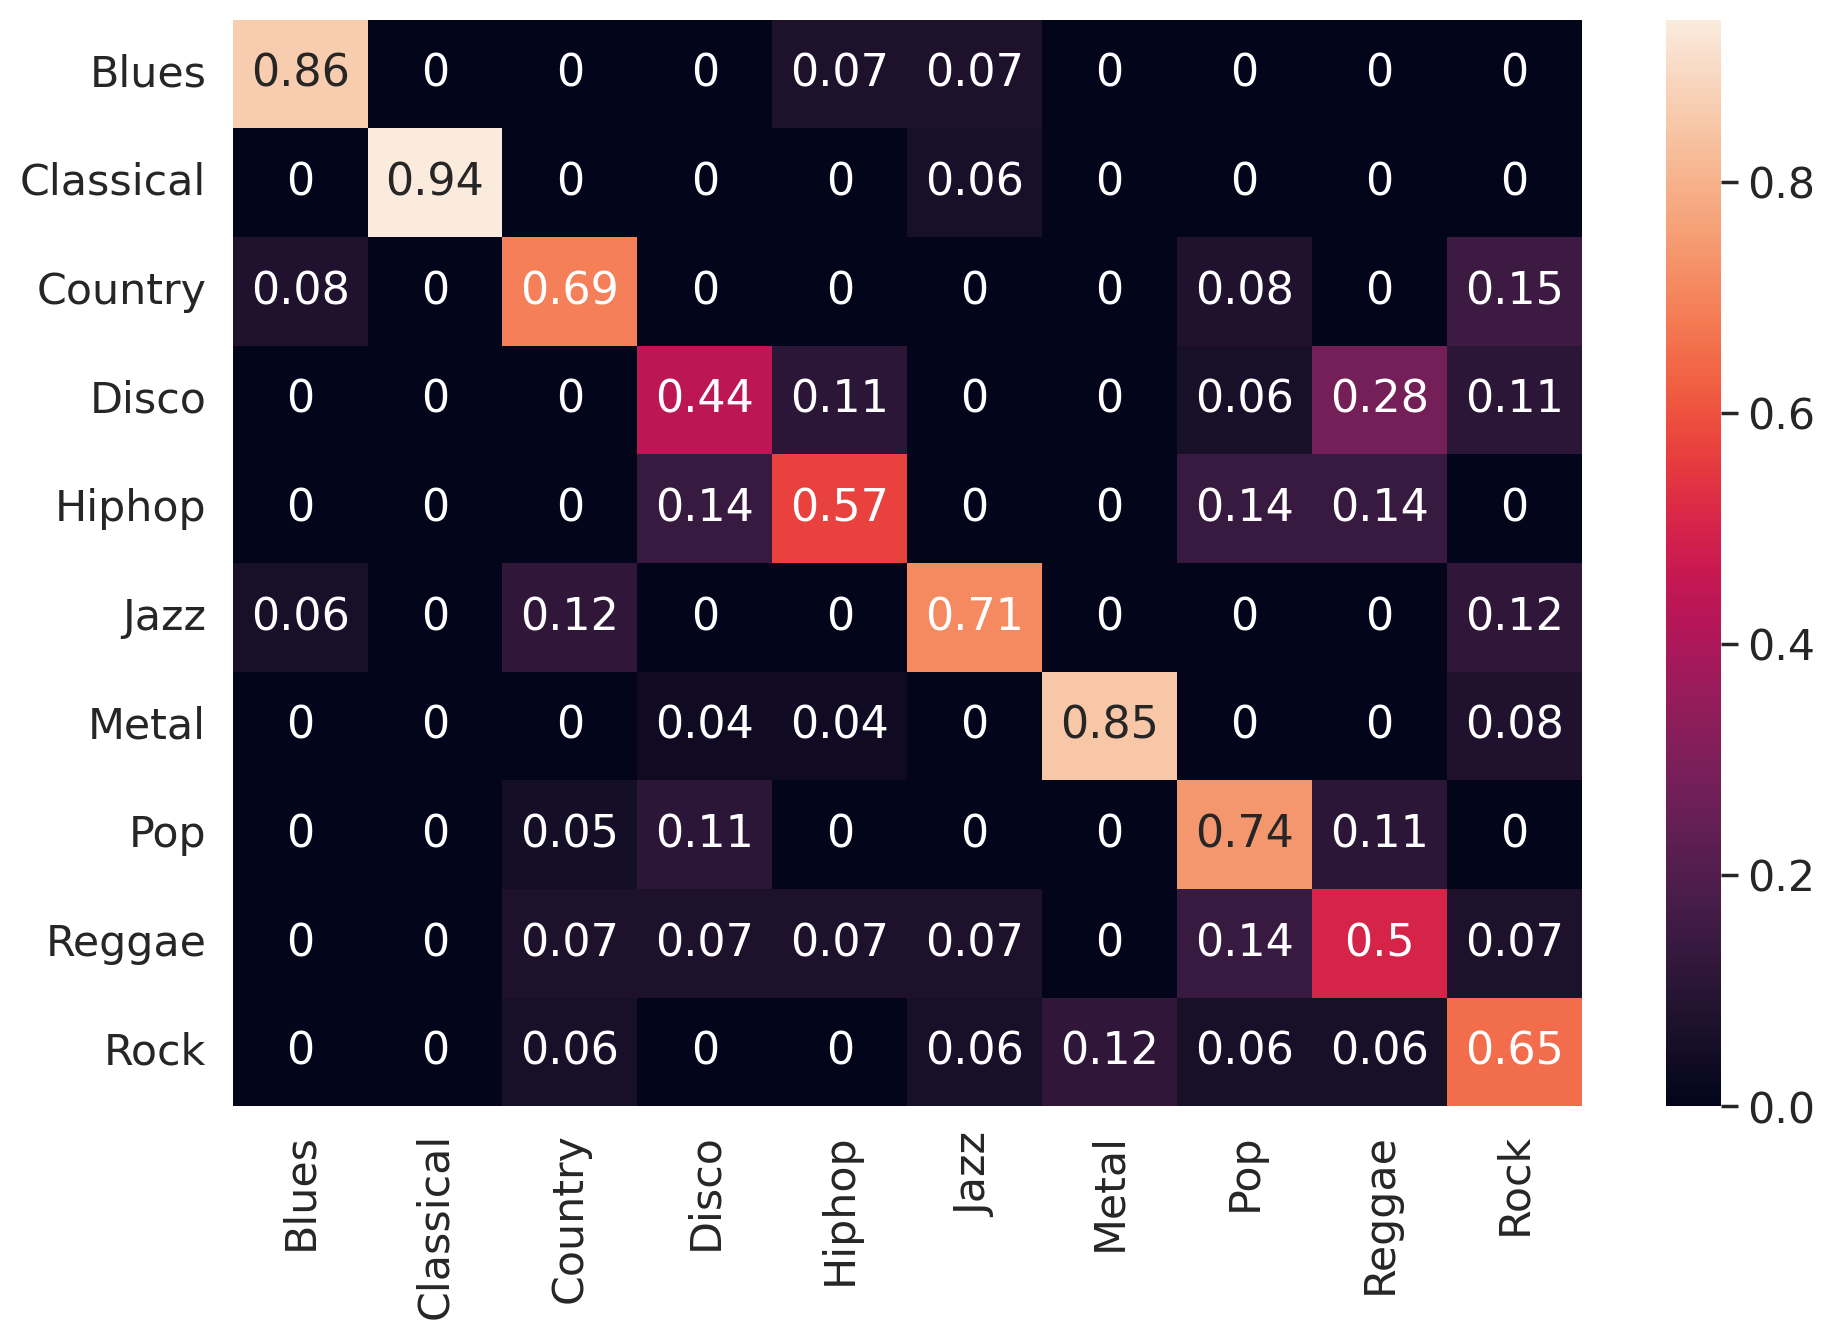

In [ ]:
#load and train the model

model = load_model(os.getcwd() + "/models/ensemble_model_melspectrogram1_100.h5")


# Training Accuracy
y_pred = model.predict(mel_train)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_train, axis= -1)

correct = len(y_pred) - np.count_nonzero(y_pred - y_true)
acc = correct/ len(y_pred)
acc = np.round(acc, 4) * 100

print("Train Accuracy: ", correct, "/", len(y_pred), " = ", acc, "%")

# Testing Accuracy
y_pred = model.predict(mel_test)
y_pred = np.argmax(y_pred, axis= -1)
y_true = np.argmax(y_test, axis= -1)

correct = len(y_pred) - np.count_nonzero(y_pred - y_true)
acc = correct/ len(y_pred)
acc = np.round(acc, 4) * 100
print("Testing Accuracy", acc)

class_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]
conf_mat = confusion_matrix(y_true, y_pred, normalize= 'true')
conf_mat = np.round(conf_mat, 2)

conf_mat_df = pd.DataFrame(conf_mat, columns= class_names, index= class_names)

plt.figure(figsize = (10,7), dpi = 200)
sn.set(font_scale=1.4)
sn.heatmap(conf_mat_df, annot=True, annot_kws={"size": 16}) # font size
plt.tight_layout()
plt.savefig(os.getcwd() + "/ensemble_mel_conf_mat1.png")

This model is clearly overfitting as the training accuracy is 100% and test accuracy is 70%

### Fix overfitting

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

# Load data
file = np.load(os.getcwd() + "/new_mel_train_test.npz")
mel_train = file['mel_train']
mel_test = file['mel_test']
y_train = file['y_train']
y_test = file['y_test']

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(mel_train)



In [ ]:
# Model definition
model = Sequential()
model.add(Conv2D(8, (3, 3), activation='relu', input_shape=mel_train[0].shape, padding='same', kernel_regularizer='l2'))
model.add(MaxPooling2D((4, 4), padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'))
model.add(MaxPooling2D((4, 4), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'))
model.add(MaxPooling2D((4, 4), padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'))
model.add(MaxPooling2D((4, 4), padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer='l2'))
model.add(MaxPooling2D((4, 4), padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Adjust the dropout rate as needed
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Adjust the dropout rate as needed
model.add(Dense(10, activation='softmax'))

# Batch normalization
model.add(BatchNormalization())

# Compile model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 1293, 8)      80        
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 32, 324, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 324, 16)       1168      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 8, 81, 16)         0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 81, 32)         4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 2, 21, 32)        

In [ ]:
# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(scheduler)

# Model checkpoint
checkpoint = ModelCheckpoint(os.getcwd() + "/models/ensemble_model_melspectrogram1_{epoch:03d}.h5", period=5)

# Train model
model.fit(datagen.flow(mel_train, y_train, batch_size=32), epochs=100, callbacks=[checkpoint, lr_scheduler], verbose=1)

# Save trained model
model.save(os.getcwd() + "/models/ensemble_model_melspectrogram1.h5")


Epoch 1/100
20/20 [==============================] - 11s 332ms/step - loss: nan - accuracy: 0.1203 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 8s 379ms/step - loss: nan - accuracy: 0.1344 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 7s 370ms/step - loss: nan - accuracy: 0.1344 - lr: 0.0010
Epoch 4/100
20/20 [==============================] - 8s 385ms/step - loss: nan - accuracy: 0.1344 - lr: 0.0010
Epoch 5/100
20/20 [==============================] - ETA: 0s - loss: nan - accuracy: 0.1344

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 8s 409ms/step - loss: nan - accuracy: 0.1344 - lr: 0.0010
Epoch 6/100
20/20 [==============================] - 8s 378ms/step - loss: nan - accuracy: 0.1344 - lr: 0.0010
Epoch 7/100
20/20 [==============================] - 8s 373ms/step - loss: nan - accuracy: 0.1344 - lr: 0.0010
Epoch 8/100
20/20 [==============================] - 8s 375ms/step - loss: nan - accuracy: 0.1344 - lr: 0.0010
Epoch 9/100
20/20 [==============================] - 8s 380ms/step - loss: nan - accuracy: 0.1344 - lr: 0.0010
Epoch 10/100
20/20 [==============================] - 8s 409ms/step - loss: nan - accuracy: 0.1344 - lr: 0.0010
Epoch 11/100
20/20 [==============================] - 8s 379ms/step - loss: nan - accuracy: 0.1344 - lr: 9.0000e-04
Epoch 12/100
20/20 [==============================] - 8s 392ms/step - loss: nan - accuracy: 0.1344 - lr: 9.0000e-04
Epoch 13/100
20/20 [==============================] - 8s 380ms/step - loss: nan - accuracy: 0.1344 - lr: 9.0000e-

20/20 [==============================] - 0s 13ms/step
Train Accuracy:  86 / 640  =  13.44 %
6/6 [==============================] - 0s 10ms/step
Testing Accuracy:  8.7


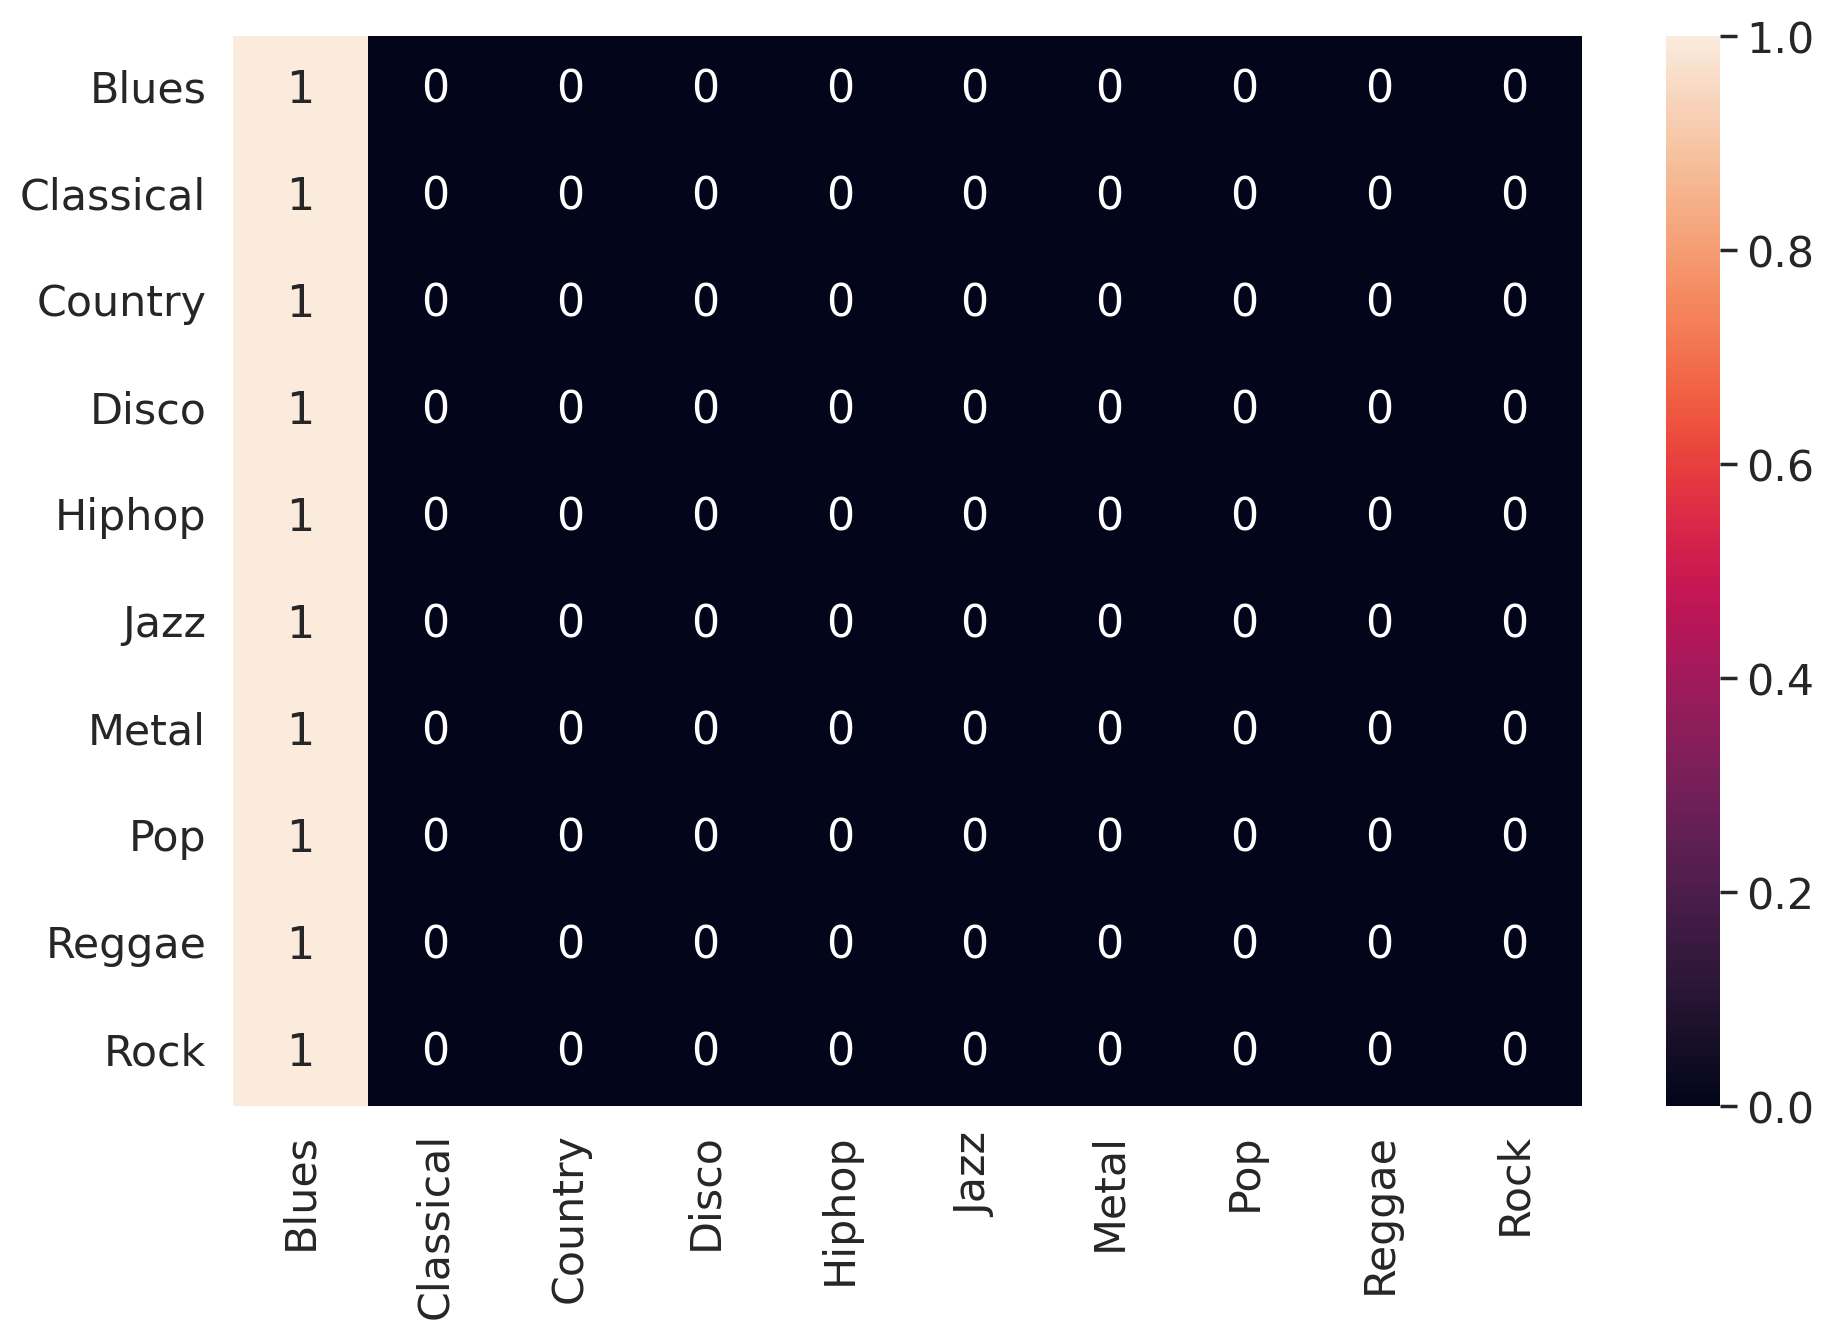

In [ ]:
# Load and evaluate the model
model = load_model(os.getcwd() + "/models/ensemble_model_melspectrogram1_100.h5")

# Training Accuracy
y_pred_train = model.predict(mel_train)
y_pred_train = np.argmax(y_pred_train, axis=-1)
y_true_train = np.argmax(y_train, axis=-1)

correct_train = len(y_pred_train) - np.count_nonzero(y_pred_train - y_true_train)
acc_train = correct_train / len(y_pred_train)
acc_train = np.round(acc_train, 4) * 100

print("Train Accuracy: ", correct_train, "/", len(y_pred_train), " = ", acc_train, "%")

# Testing Accuracy
y_pred_test = model.predict(mel_test)
y_pred_test = np.argmax(y_pred_test, axis=-1)
y_true_test = np.argmax(y_test, axis=-1)

correct_test = len(y_pred_test) - np.count_nonzero(y_pred_test - y_true_test)
acc_test = correct_test / len(y_pred_test)
acc_test = np.round(acc_test, 4) * 100
print("Testing Accuracy: ", acc_test)

# Confusion matrix
class_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]
conf_mat = confusion_matrix(y_true_test, y_pred_test, normalize='true')
conf_mat = np.round(conf_mat, 2)

conf_mat_df = pd.DataFrame(conf_mat, columns=class_names, index=class_names)

# Plot confusion matrix
plt.figure(figsize=(10, 7), dpi=200)
sn.set(font_scale=1.4)
sn.heatmap(conf_mat_df, annot=True, annot_kws={"size": 16})
plt.tight_layout()
plt.savefig(os.getcwd() + "/ensemble_mel_conf_mat1.png")


well that didnot go well ;D

### increasing model accuracy

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(mel_train)

# Model definition
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=mel_train[0].shape, padding='same'))
model.add(MaxPooling2D((4, 4), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((4, 4), padding='same'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.7))  # Adjust the dropout rate as needed
model.add(Dense(10, activation='softmax'))

# Batch normalization
model.add(BatchNormalization())

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.9
    else:
        return lr

lr_scheduler = LearningRateScheduler(scheduler)

# Model checkpoint
checkpoint = ModelCheckpoint(os.getcwd() + "/models/ensemble_model_melspectrogram_overfittingfix{epoch:03d}.h5", period=5)

# Train model
model.fit(datagen.flow(mel_train, y_train, batch_size=32), epochs=100, callbacks=[checkpoint, lr_scheduler], verbose=1)

# Save trained model
model.save(os.getcwd() + "/models/ensemble_model_melspectrogram_overfittingfix.h5")


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 128, 1293, 16)     160       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 32, 324, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 324, 32)       4640      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 8, 81, 32)         0         
 ng2D)                                                           
                                                                 
 flatten_2 (Flatten)         (None, 20736)             0         
                                                                 
 dense_6 (Dense)             (None, 64)               

Epoch 1/100
20/20 [==============================] - 9s 345ms/step - loss: 6.3189 - accuracy: 0.1172 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 8s 385ms/step - loss: 6.7963 - accuracy: 0.1172 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 8s 389ms/step - loss: 6.9175 - accuracy: 0.0953 - lr: 0.0010
Epoch 4/100
20/20 [==============================] - 8s 394ms/step - loss: 6.4226 - accuracy: 0.0984 - lr: 0.0010
Epoch 5/100
20/20 [==============================] - 8s 390ms/step - loss: 5.5304 - accuracy: 0.1219 - lr: 0.0010
Epoch 6/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 8s 399ms/step - loss: 6.2546 - accuracy: 0.1172 - lr: 0.0010
Epoch 7/100
20/20 [==============================] - 8s 386ms/step - loss: 5.3026 - accuracy: 0.0922 - lr: 0.0010
Epoch 8/100
20/20 [==============================] - 8s 389ms/step - loss: 5.5173 - accuracy: 0.1047 - lr: 0.0010
Epoch 9/100
20/20 [==============================] - 8s 379ms/step - loss: 4.9074 - accuracy: 0.1000 - lr: 0.0010
Epoch 10/100
20/20 [==============================] - 8s 397ms/step - loss: 4.9928 - accuracy: 0.0703 - lr: 0.0010
Epoch 11/100
20/20 [==============================] - 8s 386ms/step - loss: 5.1995 - accuracy: 0.1125 - lr: 9.0000e-04
Epoch 12/100
20/20 [==============================] - 8s 388ms/step - loss: 5.1194 - accuracy: 0.1078 - lr: 9.0000e-04
Epoch 13/100
20/20 [==============================] - 8s 388ms/step - loss: 4.8103 - accuracy: 0.1125 - lr: 9.0000e-04
Epoch 14/100
20/20 [==============================] - 8s 385ms/step - loss: 4.9507 -

20/20 [==============================] - 0s 14ms/step
Train Accuracy:  37 / 640  =  5.779999999999999 %
6/6 [==============================] - 0s 20ms/step
Testing Accuracy:  4.35


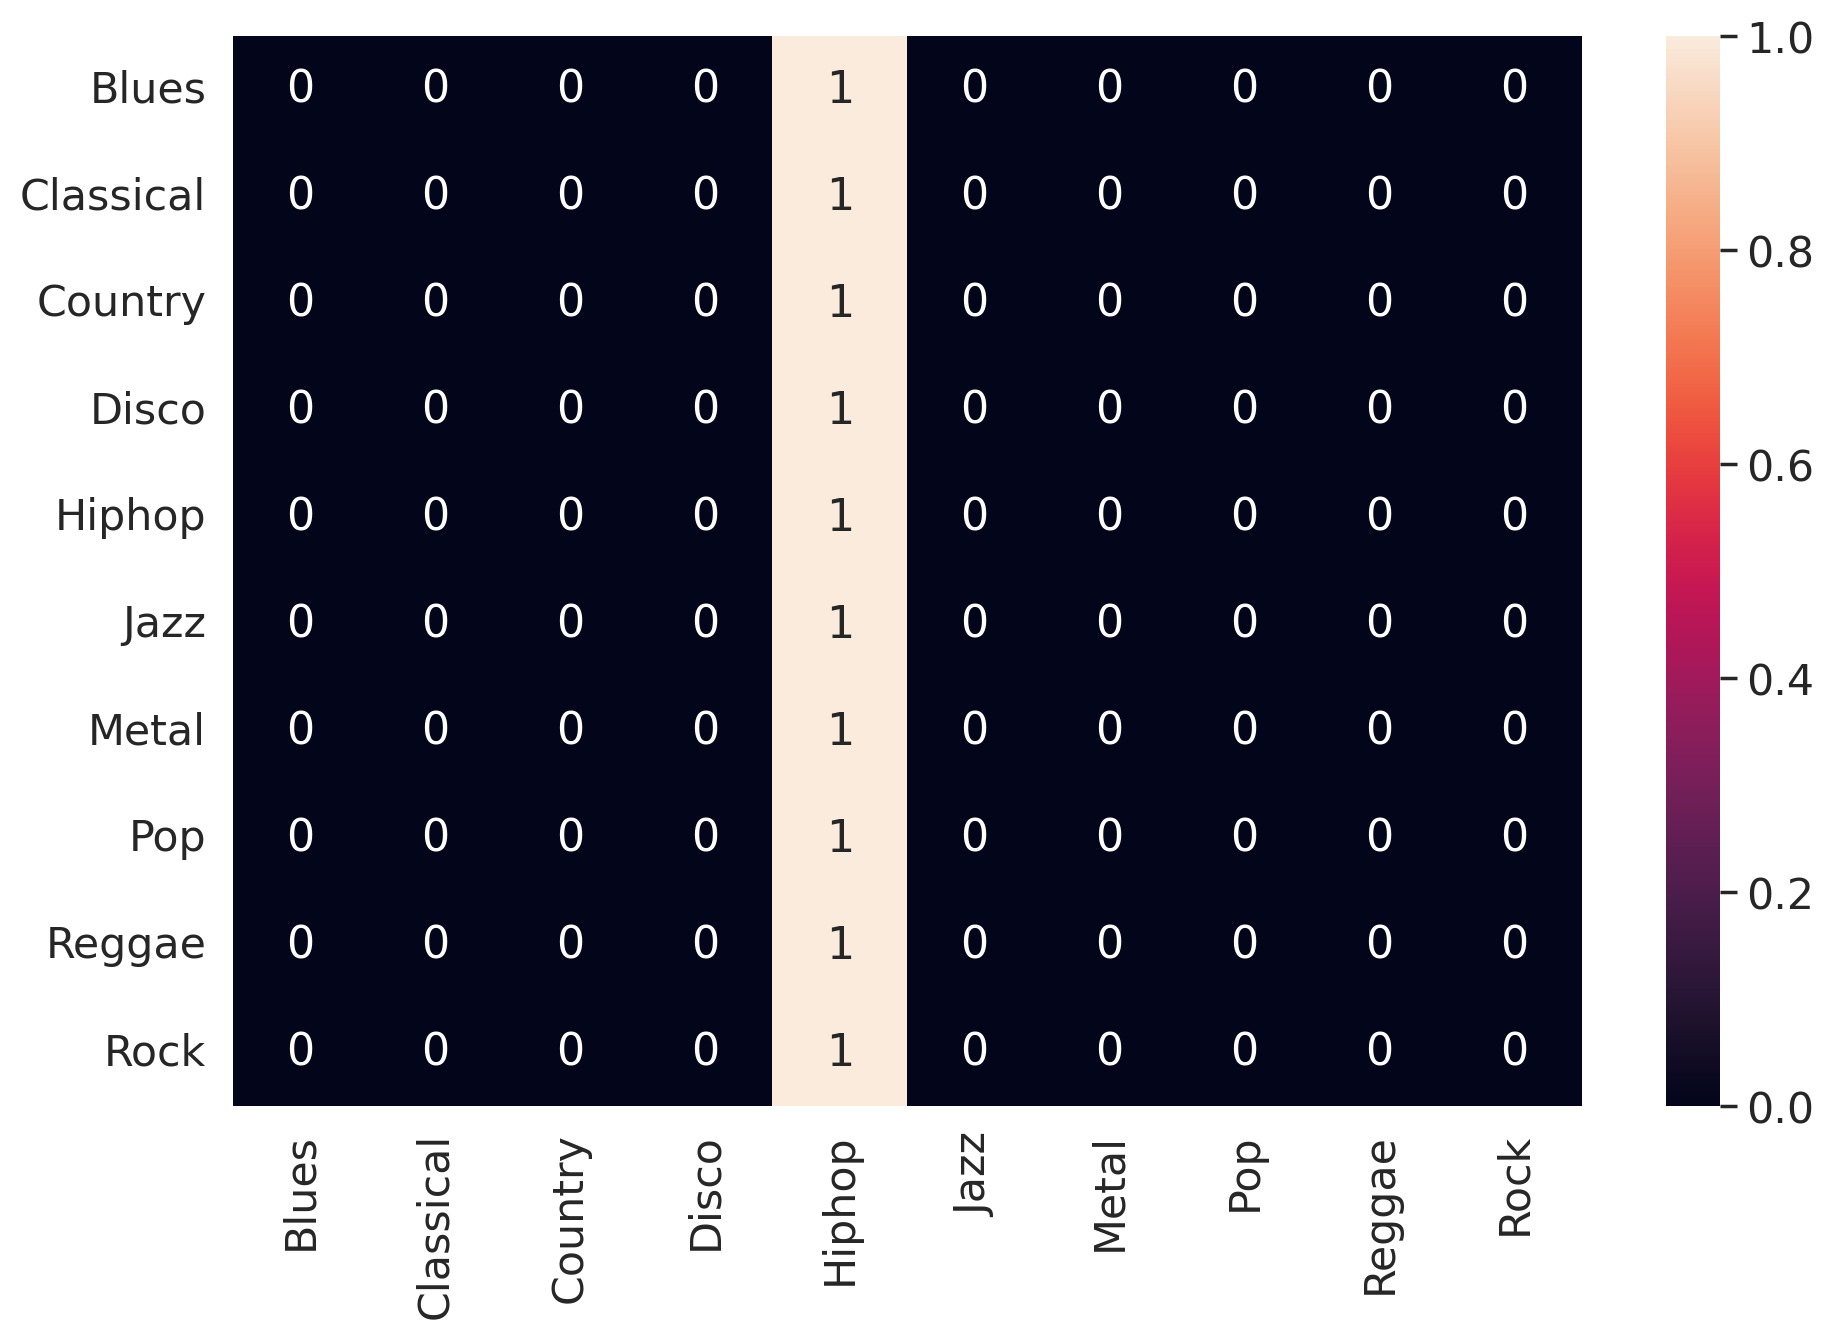

In [ ]:
# Load and evaluate the model
model = load_model(os.getcwd() + "/models/ensemble_model_melspectrogram_overfittingfix.h5")

# Training Accuracy
y_pred_train = model.predict(mel_train)
y_pred_train = np.argmax(y_pred_train, axis=-1)
y_true_train = np.argmax(y_train, axis=-1)

correct_train = len(y_pred_train) - np.count_nonzero(y_pred_train - y_true_train)
acc_train = correct_train / len(y_pred_train)
acc_train = np.round(acc_train, 4) * 100

print("Train Accuracy: ", correct_train, "/", len(y_pred_train), " = ", acc_train, "%")

# Testing Accuracy
y_pred_test = model.predict(mel_test)
y_pred_test = np.argmax(y_pred_test, axis=-1)
y_true_test = np.argmax(y_test, axis=-1)

correct_test = len(y_pred_test) - np.count_nonzero(y_pred_test - y_true_test)
acc_test = correct_test / len(y_pred_test)
acc_test = np.round(acc_test, 4) * 100
print("Testing Accuracy: ", acc_test)

# Confusion matrix
class_names = ["Blues", "Classical", "Country", "Disco", "Hiphop", "Jazz", "Metal", "Pop", "Reggae", "Rock"]
conf_mat = confusion_matrix(y_true_test, y_pred_test, normalize='true')
conf_mat = np.round(conf_mat, 2)

conf_mat_df = pd.DataFrame(conf_mat, columns=class_names, index=class_names)

# Plot confusion matrix
plt.figure(figsize=(10, 7), dpi=200)
sn.set(font_scale=1.4)
sn.heatmap(conf_mat_df, annot=True, annot_kws={"size": 16})
plt.tight_layout()
plt.savefig(os.getcwd() + "/ensemble_mel_conf_mat1.png")